In [2]:
x = [0, 10, 20, 30, 40]
rho_points = [-1168.496, -983.580, -870.513, -431.857, -31.009]

In [3]:
import scipy
import numpy as np
import matplotlib.pyplot as plt


def f(x, a, b, c, d, e):
    return a*x**4 + b*x**3 + c*x**2 + d*x + e

coeff = scipy.optimize.curve_fit(f, x, rho_points)
coeff[0]

C:\Users\hrush\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


array([-3.17014583e-03,  2.56448417e-01, -5.83359542e+00,  5.43528583e+01,
       -1.16849600e+03])

Coeff[0] has the value of a, b, c, d, e
x = vt
v = 11 cm/min


In [4]:
coef = coeff[0]
def rho(t, coef):
    soln=0
    for i in range(0, 5):
        soln += (t*11/60)**i * coef[4-i]
    return soln
        

rho(200, coef)

-106.68211522633737

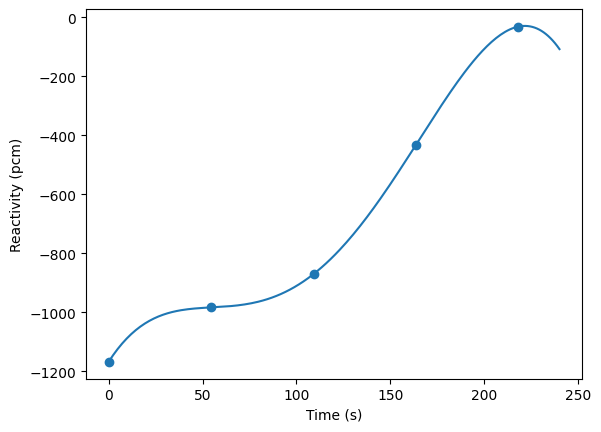

In [5]:
t = np.linspace(0, 240, 200)
y = rho(t, coef)
plt.xlabel('Time (s)')
plt.ylabel('Reactivity (pcm)')
plt.scatter(np.array(x)*60/11, rho_points)
plt.plot(t, y)


In [6]:
beta_ = np.array([0.000213, 0.001413, 0.001264, 0.002548, 0.000742, 0.000271])
lambda_ = np.array([0.01244, 0.0305, 0.1114, 0.3013, 1.1361, 3.013])
n_0 = 70000
LAMBDA = 8.13*10**(-5)
c_0 = beta_*n_0/LAMBDA/lambda_
S_0 = 10000000
c_0

array([14742349.99584722, 39888693.96890689,  9769433.42144373,
        7281280.91105006,   562334.64367915,    77442.19493307])

In [21]:
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate
# Import tf if using backend tensorflow.compat.v1 or tensorflow
from deepxde.backend import tf

def func(t, y):
    n, c1, c2, c3, c4, c5, c6 = y  
    dn_dt = S_0 + (rho(t, coef) - sum(beta_)) * n / LAMBDA + np.dot(lambda_, y[1:])
    dc1_dt = beta_[0] * n / LAMBDA - lambda_[0] * c1
    dc2_dt = beta_[1] * n / LAMBDA - lambda_[1] * c2
    dc3_dt = beta_[2] * n / LAMBDA - lambda_[2] * c3
    dc4_dt = beta_[3] * n / LAMBDA - lambda_[3] * c4
    dc5_dt = beta_[4] * n / LAMBDA - lambda_[4] * c5
    dc6_dt = beta_[5] * n / LAMBDA - lambda_[5] * c6

    return dn_dt, dc1_dt, dc2_dt, dc3_dt, dc4_dt, dc5_dt, dc6_dt

def gen_truedata():
    t = np.linspace(0, 4, 100)
    sol = integrate.solve_ivp(func, (0, 4), (n_0, *c_0), t_eval=t)
    n_true, c1_true, c2_true, c3_true, c4_true, c5_true, c6_true = sol.y
    n_true = n_true.reshape(100, 1)
    c1_true = c1_true.reshape(100, 1)
    c2_true = c2_true.reshape(100, 1)
    c3_true = c3_true.reshape(100, 1)
    c4_true = c4_true.reshape(100, 1)
    c5_true = c5_true.reshape(100, 1)
    c6_true = c6_true.reshape(100, 1)    

    return (n_true, c1_true, c2_true, c3_true, c4_true, c5_true, c6_true)  

def ode_system(x, y):
    n, c1, c2, c3, c4, c5, c6 = y[:, 0:1], y[:, 1:2], y[:,2:3], y[:, 3:4], y[:, 4:5], y[:, 5:6], y[:, 6:]  
    dn_dt = dde.grad.jacobian(y, x, i=0)
    dc1_dt = dde.grad.jacobian(y, x, i=1)
    dc2_dt = dde.grad.jacobian(y, x, i=2)
    dc3_dt = dde.grad.jacobian(y, x, i=3)
    dc4_dt = dde.grad.jacobian(y, x, i=4)
    dc5_dt = dde.grad.jacobian(y, x, i=5)
    dc6_dt = dde.grad.jacobian(y, x, i=6)

    soln = [
        dn_dt - (S_0 + (rho(x, coef) - sum(beta_)) * n / LAMBDA + tf.reduce_sum(lambda_ * y[:, 1:], axis=1, keepdims=True)), 
        dc1_dt - (beta_[0] * n / LAMBDA - lambda_[0] * c1),
        dc2_dt - (beta_[1] * n / LAMBDA - lambda_[1] * c2),
        dc3_dt - (beta_[2] * n / LAMBDA - lambda_[2] * c3),
        dc4_dt - (beta_[3] * n / LAMBDA - lambda_[3] * c4),
        dc5_dt - (beta_[4] * n / LAMBDA - lambda_[4] * c5),
        dc6_dt - (beta_[5] * n / LAMBDA - lambda_[5] * c6),
    ]
    return soln

geom = dde.geometry.TimeDomain(0, 1)

# No initial or boundary conditions are specified as it is an initial value problem.
data = dde.data.PDE(geom, ode_system, [], num_domain=100, num_boundary=10, num_test=50)

layer_size = [1] + [64] * 6 + [7]
activation = "tanh"
initializer = "Glorot normal"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)

model.compile("adam", lr=0.001)

Compiling model...
Building feed-forward neural network...


C:\Users\hrush\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'build' took 0.238162 s



NotImplementedError: Cannot convert a symbolic tf.Tensor (mul_148:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported.

Compiling model...
Building feed-forward neural network...


C:\Users\hrush\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'build' took 0.275399 s

'compile' took 3.895524 s

Training model...

0         [1.59e+14, 1.66e-01, 1.13e+01, 8.85e+00, 3.78e+01, 5.17e+00, 3.09e-01]    [1.60e+14, 1.59e-01, 1.15e+01, 8.97e+00, 3.84e+01, 5.25e+00, 3.06e-01]    []  
1000      [4.95e+08, 3.97e+00, 1.53e+02, 1.21e+02, 4.84e+02, 3.05e+01, 6.55e+00]    [3.86e+08, 3.96e+00, 1.53e+02, 1.21e+02, 4.84e+02, 3.04e+01, 6.60e+00]    []  
2000      [2.10e+08, 3.94e+00, 1.53e+02, 1.21e+02, 4.84e+02, 3.03e+01, 7.01e+00]    [1.61e+08, 3.93e+00, 1.53e+02, 1.21e+02, 4.84e+02, 3.02e+01, 7.05e+00]    []  
3000      [2.20e+09, 3.92e+00, 1.51e+02, 1.20e+02, 4.80e+02, 3.01e+01, 7.09e+00]    [2.19e+09, 3.90e+00, 1.51e+02, 1.20e+02, 4.79e+02, 3.00e+01, 7.14e+00]    []  
4000      [9.89e+09, 3.76e+00, 1.50e+02, 1.20e+02, 4.75e+02, 2.97e+01, 6.69e+00]    [9.92e+09, 3.75e+00, 1.50e+02, 1.20e+02, 4.75e+02, 2.96e+01, 6.74e+00]    []  
5000      [8.20e+07, 3.71e+00, 1.53e+02, 1.23e+02, 4.85e+02, 3.04e+01, 6.86e+00]    [6.34e+07, 3.70e+00, 1.53e+02,

ValueError: Cannot feed value of shape () for Tensor Placeholder_10:0, which has shape (None, 1)

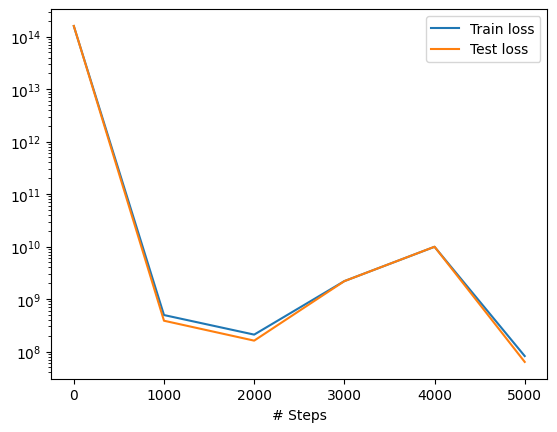

In [16]:


losshistory, train_state = model.train(iterations=5000)

# Plot the training loss
dde.utils.plot_loss_history(losshistory)

t = np.linspace(0, 4, 100).reshape(100, 1)
# Predict using the trained model
y_pred = model.predict(0)
n_pred = y_pred[:, 0:1]

In [22]:
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate
# Import tf if using backend tensorflow.compat.v1 or tensorflow
from deepxde.backend import tf

def func(t, y):
    n, c1, c2, c3, c4, c5, c6 = y
    dn_dt = S_0 + (rho(t, coef) - sum(beta_)) * n / LAMBDA + np.dot(lambda_, y[1:])
    dc1_dt = beta_[0] * n / LAMBDA - lambda_[0] * c1
    dc2_dt = beta_[1] * n / LAMBDA - lambda_[1] * c2
    dc3_dt = beta_[2] * n / LAMBDA - lambda_[2] * c3
    dc4_dt = beta_[3] * n / LAMBDA - lambda_[3] * c4
    dc5_dt = beta_[4] * n / LAMBDA - lambda_[4] * c5
    dc6_dt = beta_[5] * n / LAMBDA - lambda_[5] * c6

    return dn_dt, dc1_dt, dc2_dt, dc3_dt, dc4_dt, dc5_dt, dc6_dt

def gen_truedata():
    t = np.linspace(0, 250, 100)
    sol = integrate.solve_ivp(func, (0, 250), (n_0, *c_0), t_eval=t)
    n_true, c1_true, c2_true, c3_true, c4_true, c5_true, c6_true = sol.y
    n_true = n_true.reshape(100, 1)
    c1_true = c1_true.reshape(100, 1)
    c2_true = c2_true.reshape(100, 1)
    c3_true = c3_true.reshape(100, 1)
    c4_true = c4_true.reshape(100, 1)
    c5_true = c5_true.reshape(100, 1)
    c6_true = c6_true.reshape(100, 1)

    return (n_true, c1_true, c2_true, c3_true, c4_true, c5_true, c6_true)

def ode_system(x, y):
    n, c1, c2, c3, c4, c5, c6 = y[:, 0:1], y[:, 1:2], y[:,2:3], y[:, 3:4], y[:, 4:5], y[:, 5:6], y[:, 6:]
    dn_dt = dde.grad.jacobian(y, x, i=0)
    dc1_dt = dde.grad.jacobian(y, x, i=1)
    dc2_dt = dde.grad.jacobian(y, x, i=2)
    dc3_dt = dde.grad.jacobian(y, x, i=3)
    dc4_dt = dde.grad.jacobian(y, x, i=4)
    dc5_dt = dde.grad.jacobian(y, x, i=5)
    dc6_dt = dde.grad.jacobian(y, x, i=6)

    soln = [
        dn_dt - (S_0 + (rho(x, coef) - sum(beta_)) * n / LAMBDA + tf.reduce_sum(lambda_ * y[:, 1:], axis=1, keepdims=True)),
        dc1_dt - (beta_[0] * n / LAMBDA - lambda_[0] * c1),
        dc2_dt - (beta_[1] * n / LAMBDA - lambda_[1] * c2),
        dc3_dt - (beta_[2] * n / LAMBDA - lambda_[2] * c3),
        dc4_dt - (beta_[3] * n / LAMBDA - lambda_[3] * c4),
        dc5_dt - (beta_[4] * n / LAMBDA - lambda_[4] * c5),
        dc6_dt - (beta_[5] * n / LAMBDA - lambda_[5] * c6),
    ]
    return soln

geom = dde.geometry.TimeDomain(0, 250)

# No initial or boundary conditions are specified as it is an initial value problem.
data = dde.data.PDE(geom, ode_system, [], num_domain=300, num_boundary=10, num_test=3000)

layer_size = [1] + [256] * 6 + [7]
activation = "tanh"
initializer = "Glorot normal"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)

model.compile("adam", lr=0.001)

Compiling model...
Building feed-forward neural network...
'build' took 0.111645 s



C:\Users\hrush\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


NotImplementedError: Cannot convert a symbolic tf.Tensor (mul_149:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported.